In [1]:
import spatialdata
import sopa

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


# Context

Sopa is built on top of the [`spatialdata` library](https://github.com/scverse/spatialdata), the core **scverse** data structure.

It means that Sopa will manipulate `SpatialData` objects, that we usually denote by `sdata`. For users familiar with `anndata`, `spatialdata` can be seen as an extension for spatial omics.

All the functions from `SpatialData` are therefore also available. For instance, at any time of the pipeline below, you can save your object via `sdata.write("data.zarr")` and load it via `spatialdata.read_zarr("data.zarr")`.

## Create a SpatialData object

For this tutorial, we use a generated dataset.

To load your own data, you need to use the function from [`sopa.io`](../../api/io) that is specific to your technology.

> For instance, for MERSCOPE data, use `sdata = sopa.io.merscope("/path/to/region_0")`.

In [33]:
sdata = sopa.io.toy_dataset() # you can use `sopa.io.merscope` / `sopa.io.xenium` / ...

sdata

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell


SpatialData object
├── Images
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (3D points)
└── Shapes
      └── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        image (Images), transcripts (Points), cells (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

# Tissue segmentation

Before cell segmentation, it is possible to perform tissue segmentation. This way, later on, we will run cell segmentation only over the tissue, not outside.

## Cell segmentation

### Option 1: Cellpose

First, we generate the bounding boxes of the patches on which Cellpose will be run. Here, the patches have a width and height of 1500 pixels and an overlap of 50 pixels. We advise bigger sizes for real datasets (see our default parameters in one of our [config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config)). On the toy dataset, this will generate **4** patches.

In [34]:
sopa.make_image_patches(sdata, patch_width=1200, patch_overlap=50)

[INFO] (sopa.patches.patches) 4 patches were saved in sdata['sopa_patches']


The following channels are available for segmentation. Choose one or two channels used by Cellpose.

In [35]:
sopa.utils.get_channel_names(sdata)

array(['DAPI', 'CK', 'CD3', 'CD20'], dtype='<U4')

Then, we run Cellpose. Here, we run segmentation using DAPI only, and we set the cell diameter to be about `35` pixels.
> NB: to make is faster, we can set a parallelization backend as below.

In [38]:
# optional: set the parallelization backend to use dask
sopa.settings.parallelization_backend = "dask"

In [39]:
sopa.segmentation.cellpose(sdata, channels=["DAPI"], diameter=35)

[WARNING] (sopa._settings) Running without parallelization backend can be slow. Consider using a backend, e.g. `sopa.settings.parallelization_backend = 'dask'`.
100%|██████████| 4/4 [00:36<00:00,  9.01s/it]
[INFO] (sopa.segmentation.stainings) Found 411 total cells
Resolving conflicts: 100%|██████████| 126/126 [00:00<00:00, 8490.63it/s]
[INFO] (sopa.segmentation.stainings) Added 372 cell boundaries in sdata['cellpose_boundaries']


### Option 2: Baysor

Baysor needs a config to be executed. You can find official config examples [here](https://github.com/kharchenkolab/Baysor/tree/master/configs). You can also reuse the Baysor parameter we have defined for each machine, as in our [Snakemake config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config).

For this tutorial, we will use the config as a dictionnary. Instead, you can also create a `.toml` config file and use the `config_path` argument inside the `sopa.segmentation.baysor` function below.

In [4]:
config = {
    "data": {
        "force_2d": True,
        "min_molecules_per_cell": 10,
        "x": "x",
        "y": "y",
        "z": "z",
        "gene": "genes",
        "min_molecules_per_gene": 0,
        "min_molecules_per_segment": 3,
        "confidence_nn_id": 6
    },
    "segmentation": {
        "scale": 3,  # Important parameter: typical cell diameter, in microns (see our configs)
        "scale_std": "25%",
        "prior_segmentation_confidence": 0,
        "estimate_scale_from_centers": False,
        "n_clusters": 4,
        "iters": 500,
        "n_cells_init": 0,
        "nuclei_genes": "",
        "cyto_genes": "",
    }
}

Before actually running Baysor, we generate the bounding boxes of the patches on which Baysor will be run. Here, the patches have a width and height of 3000 microns and an overlap of 50 microns. We advise bigger sizes for real datasets (see our default parameters in one of our [config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config)).

In [23]:
sopa.make_transcript_patches(sdata, patch_width=500)

[INFO] (sopa.patches.patches) Writing sub-CSV for transcript segmentation


[########################################] | 100% Completed | 358.78 ms


[INFO] (sopa.patches.patches) 1 patche(s) saved in directory /Users/quentinblampey/.sopa_cache/855462a3-f042-462d-9cf1-5edf52c4439f/transcript_patches
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `sopa_patches_transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Then, we can run Baysor on each patch, and combine the results.

> NB: to make is faster, we can set a parallelization backend as below.

In [6]:
# optional: set the parallelization backend to use dask
sopa.settings.parallelization_backend = "dask"

In [7]:
sopa.segmentation.baysor(sdata, config=config, min_area=10)

[INFO] (sopa._settings) Using dask backend


[INFO] (sopa.segmentation.transcripts) Cells whose area is less than 10 microns^2 will be removed
Reading transcript-segmentation outputs:   0%|          | 0/16 [00:00<?, ?it/s]/Users/quentinblampey/Library/Caches/pypoetry/virtualenvs/sopa-hDHgkEug-py3.9/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Resolving conflicts: 100%|██████████| 4150/4150 [00:00<00:00, 10254.79it/s]
[INFO] (sopa.segmentation.transcripts) Aggregating transcripts on merged cells
[INFO] (sopa.aggregation.transcripts) Aggregating transcripts over 321 cells


[########################################] | 100% Completed | 217.92 ms


[INFO] (sopa.segmentation.transcripts) Added sdata.tables['table'], and 376 cell boundaries to sdata['baysor_boundaries']


## Aggregation

The purpose of aggregation is to create an `AnnData` object of features per cell. Depending on your technology, it will count the transcript/bins inside each cell, and/or average each channel intensity inside each cell boundary.

More specifically:
- For bins technologies like Visium HD data: for each cell, it will sum the transcript counts of all bins that are touching this cell.
- For transcript-based technologies like MERSCOPE/Xenium, it will count the transcripts inside each cells, and optionally average the channel intensities
- For multiplex imaging data, it will average the intensity of each channel inside each cell

In [40]:
sopa.aggregate(sdata)

[INFO] (sopa.aggregation.transcripts) Aggregating transcripts over 372 cells


[########################################] | 100% Completed | 104.99 ms


[INFO] (sopa.aggregation.channels) Averaging channels intensity over 372 cells with expansion expand_radius_ratio=0


[########################################] | 100% Completed | 107.59 ms


[INFO] (sopa.aggregation.aggregation) Filtering 0 cells
/Users/quentinblampey/dev/sopa/sopa/aggregation/aggregation.py:167: ImplicitModificationWarning: Setting element `.obsm['intensities']` of view, initializing view as actual.
  self.table.obsm[SopaKeys.INTENSITIES_OBSM] = pd.DataFrame(
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Now, in the `SpatialData` object, there is a `"table"` element (which is an `AnnData` object, see below).

In [41]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 372 × 6
    obs: 'region', 'slide', 'cell_id', 'area'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'intensities', 'spatial'

What's inside adata depends on your technology:
- If you have transcripts/bins, then `adata.X` are the raw counts
- Else, `adata.X` are the channels intensities
- If you both count the transcript/bins and average the intensities, then `adata.X` are the raw counts, and `adata.obsm["intensities"]` are the channels intensities (as above)

## Annotation

Annotation within Sopa is totally optionnal. These annotations tools were optimized for annotation of large data, but feel free to perform your own.

#### Option 1: Transcript-based (Tangram)

[Tangram](https://github.com/broadinstitute/Tangram) is a transcript-based annotation that uses an annotated single-cell reference. Let's suppose your reference `AnnData` object is stored in a file called `adata_reference.h5ad` (preferably, keep raw counts), and the cell type is in `adata.obs["cell_type"]`. Then, you can annotate your spatial data as follows:

In [ ]:
import anndata

adata_reference = anndata.read_h5ad("adata_reference.h5ad")

sopa.utils.tangram_annotate(sdata, adata_reference, "cell_type")

#### Option 2: Staining-based
For now, our fluorescence-based annotation is very simple. We provide a dictionary where a channel is associated with a population. Then, each cell is associated with the cell type whose corresponding channel is the brightest (according to a certain Z-score). In this tutorial example, we can annotate Tumoral cells, T cells, and B cells:

In [42]:
marker_cell_dict = {
    "CK": "Tumoral cell",
    "CD20": "B cell",
    "CD3": "T cell"
}

sopa.utils.higher_z_score(sdata.tables["table"], marker_cell_dict)

[INFO] (sopa.utils.annotation) Annotation counts: cell_type
Tumoral cell    129
T cell          123
B cell          120
Name: count, dtype: int64


## Visualization

Many visualization tools can be used. Here, we show three of them, with different capabilities.

### With napari-spatialdata

[`napari-spatialdata`](https://github.com/scverse/napari-spatialdata) is a plugin for [Napari](https://napari.org/stable/) developed to visualize your SpatialData objects.

This visualizer is very flexible, as you can display any spatial element, and you can directly save annotations from Napari in your SpatialData object.

### With the Xenium Explorer

The Xenium Explorer is a software developed by 10X Genomics for visualizing spatial data, and it can be downloaded freely [here](https://www.10xgenomics.com/support/software/xenium-explorer/latest). This is the most user-friendly visualizer of the three, but it may not show all the spatial element from your `SpatialData` object (it only shows images, transcripts, and cell boundaries).

Sopa allows the conversion to the Xenium Explorer, whatever the type of spatial data you worked on.

The command below creates some files under a new `tuto.explorer` directory:

In [12]:
sopa.io.write("tuto.explorer", sdata, image_key, points_key=points_key, gene_column=gene_column)

[INFO] (sopa.io.explorer.table) Writing table with 5 columns
[INFO] (sopa.io.explorer.table) Writing 3 cell categories: region, slide, cell_type
[INFO] (sopa.io.explorer.shapes) Writing 367 cell polygons
[INFO] (sopa.io.explorer.points) Writing 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 0: 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 1: 10000 transcripts
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (4, 2048, 2048)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 2048, 2048)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 1024, 1024)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 512, 512)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 256, 256)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 128, 128)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 64, 64)
[I

If you have downloaded the Xenium Explorer, you can now open the results in the explorer: simply double-click on the `tuto.explorer/experiment.xenium` file.

### With spatialdata-plot
[`spatialdata-plot`](https://github.com/scverse/spatialdata-plot) library is a static plotting library for `SpatialData` objects. This solution is very convenient when working in Jupyter Notebooks.

In [43]:
import spatialdata_plot # you can install it via `pip install spatialdata-plot`

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


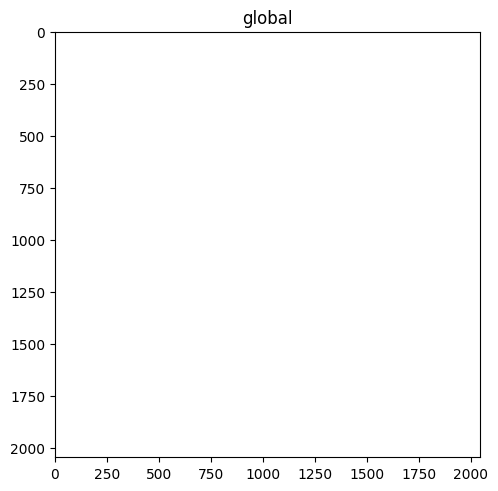

In [51]:
sdata\
    .pl.render_images()\
    .pl.render_points(size=0.01, color="#ffffff", alpha=0.5)\
    .pl.render_shapes("cellpose_boundaries", outline=True, fill_alpha=0, outline_color="k")\
    .pl.show("global")

## Pipeline report
You can optionally create an HTML report of the pipeline run (in the example below, we save it under `report.html`). It contains some quality controls for your data.

In [53]:
sopa.io.write_report("report.html", sdata)

[INFO] (sopa.io.report.generate) Writing general_section
[INFO] (sopa.io.report.generate) Writing cell_section
[INFO] (sopa.io.report.generate) Writing channel_section
[INFO] (sopa.io.report.generate) Writing transcripts_section
[INFO] (sopa.io.report.generate) Writing representation_section
[INFO] (sopa.io.report.generate) Computing UMAP on 372 cells
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[INFO] (sopa.io.report.generate) Writing report to report.html


## Further analyses

If not done yet, you can save your SpatialData object, as below. It will create a `.zarr` directory.

In [ ]:
sdata.write("tuto.zarr")

This way, you'll be able to open it later for further analysis, using `spatialdata.read_zarr("tuto.zarr")`.

Now, here is a list of ressources you may consider to go further:
- [This tutorial](../spatial) on spatial statistic and geometric analysis.
- Use [Squidpy](https://squidpy.readthedocs.io/en/latest/index.html) which operates on both the `SpatialData` object or the `AnnData` object, or use other tools of the `scverse` ecosystem such as [`Scanpy`](https://scanpy.readthedocs.io/en/stable/index.html).
- You can also try the CLI or the Snakemake pipeline of Sopa.